In [1]:
import pandas as pd
import numpy as np
from math import log10
from math import log
import matplotlib.pyplot as plt
from scipy import stats

## Ingredients Case Study on Predictive Alerting

In [2]:
import pandas as pd

ferrero_corp = pd.read_csv('data/ferrero_corporate.csv')
ferrero_corp_auth = pd.read_csv('data/authority_filtered/ferrero_corp_auth.csv')

C:\Users\alxau\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,4,44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def get_user_scale():
    s = pd.Series(np.exp(np.linspace(1, 10, 101)))
    return (s -s.min())/ s.max() * 50 + 1


def get_text_weight(df):
    df = df.loc[df['score_engagement'].dropna().index]
    df['percentile'] = get_user_percentile(df['score_engagement'])
    scale = get_user_scale()
    df['text_weighted'] = df['percentile'].apply(lambda x: scale[round(x)])
    return df


def get_user_percentile(series):
    return series.apply(lambda x: stats.percentileofscore(series, x))


def get_days(irisdataset, thresh):
    return irisdataset[irisdataset['mIndex'] > thresh][['mIndex', 'sign']]


# Same as get_days, but on the left or right side of a merged dataset
def get_days_left(irisdataset, thresh):
    return irisdataset[irisdataset['mIndex_x'] > thresh][['mIndex_x', 'sign_x']]


def get_days_right(irisdataset, thresh):
    return irisdataset[irisdataset['mIndex_y'] > thresh][['mIndex_y', 'sign_y']]


def get_polarity(df):
    positive_emotions = ['emotion_joy', 'emotion_admiration']
    negative_emotions = ['emotion_fear', 'emotion_anger', 'emotion_disapproval']
    
    positive = df['emotion_joy'] + df['emotion_admiration']
    positive = positive.fillna(positive.mean())
    
    negative = df['emotion_fear'] + df['emotion_anger'] + df['emotion_disapproval']
    negative = negative.fillna(negative.mean())

    total = positive + negative
    df['sentiment_value'] = positive / total
    return df


def iris(dataf, weight_by_user=False):
    dataset = dataf.copy()
                       
    if weight_by_user:
        dataset = get_text_weight(dataset)
        
    dataset = get_polarity(dataset)
        
    if weight_by_user:
        dataset = dataset[['date_created_at', 'sentiment_value', 'text_weighted']]
    else:
        dataset = dataset[['date_created_at', 'sentiment_value']]

#     dataset['date_index'] = pd.DatetimeIndex(dataset.date_created_at)
    dataset['date_index'] =  pd.to_datetime(dataset.date_created_at,  errors='coerce')
    dataset = dataset.loc[dataset['date_index'].dropna().index]
    
    volumes = dataset.groupby(pd.Grouper(key='date_index', freq='d')).count()['sentiment_value']
    mean_sent = dataset.groupby(pd.Grouper(key='date_index', freq='d')).mean()['sentiment_value']
        
    if weight_by_user:
        tmp = dataset[['date_index', 'text_weighted']]
        weighted_volumes = tmp.groupby(pd.Grouper(key='date_index', freq='d')).sum()['text_weighted']
        volume_medians = weighted_volumes.rolling(window=14).median()
    else:
        volume_medians = volumes.rolling(window=14).median()

    mean_sent_abs = abs(mean_sent - 0.5) + 1
    
    if weight_by_user:
        index = (weighted_volumes / volume_medians - 1) * mean_sent_abs
    else:
        index = (volumes / volume_medians - 1) * mean_sent_abs
        
    return pd.DataFrame({'mIndex': index, 
                         'volume': volumes, 
                         'sentiment': mean_sent, 
                         'sign': (mean_sent - 0.5) > 0})


In [4]:
def plot_iris(iris, threshold):

    fig = plt.figure(figsize=(10, 8), constrained_layout=True)
    axs = fig.subplots(2,1)

    plt.sca(axs[0])
    plt.xticks(rotation=45)

    axs[0].set_title('Volumes')
    axs[0].grid(True)
    axs[0].plot(iris.index.values, iris['volume'])

    plt.sca(axs[1])
    plt.xticks(rotation=45)

    axs[1].set_title('Alert Spectrum')
    axs[1].grid(True)
    axs[1].plot(iris.index.values, iris['mIndex'])


    print('####  Peaks found ####')
    print(get_days(iris, threshold))

    print('\n####  Charts ####')


In [5]:
def plot_auth_spikes(df, threshold):
    
    fig = plt.figure(figsize=(10, 8), constrained_layout=True)
    
    ax = fig.subplots(2,1)
    plt.sca(ax[0])
    plt.xticks(rotation=45)
    
    ax0_auth = ax[0].twinx()

    plt.sca(ax[1])
    plt.xticks(rotation=45)

    ax1_auth = ax[1].twinx()

    color = 'tab:blue'

    ax[0].set_title('Volumes')
    ax[0].grid(True)
    ax[0].plot(df.index.values, df['volume_y'])
    ax[0].tick_params(axis='y', labelcolor=color)

    ax[1].set_title('Alert Spectrum')
    ax[1].grid(True)
    ax[1].plot(df.index.values, df['mIndex_y'])
    ax[1].tick_params(axis='y', labelcolor=color)

    color = 'tab:orange'
    
    ax0_auth.plot(df.index.values, df['volume_x'], color=color)
    ax0_auth.tick_params(axis='y', labelcolor=color)

    ax1_auth.plot(df.index.values, df['mIndex_x'], color=color)
    ax1_auth.tick_params(axis='y', labelcolor=color)

####  Peaks found ####
                              mIndex   sign
date_index                                 
2019-08-20 00:00:00+00:00   2.602240  False
2019-08-21 00:00:00+00:00  13.554951  False
2019-08-22 00:00:00+00:00   5.825910  False
2019-08-23 00:00:00+00:00   2.485722  False
2019-08-24 00:00:00+00:00   1.006199  False
...                              ...    ...
2021-08-19 00:00:00+00:00   0.774941   True
2021-08-20 00:00:00+00:00   0.858849  False
2021-08-23 00:00:00+00:00   2.040529  False
2021-08-24 00:00:00+00:00   1.287879  False
2021-08-25 00:00:00+00:00   0.679956  False

[165 rows x 2 columns]

####  Charts ####


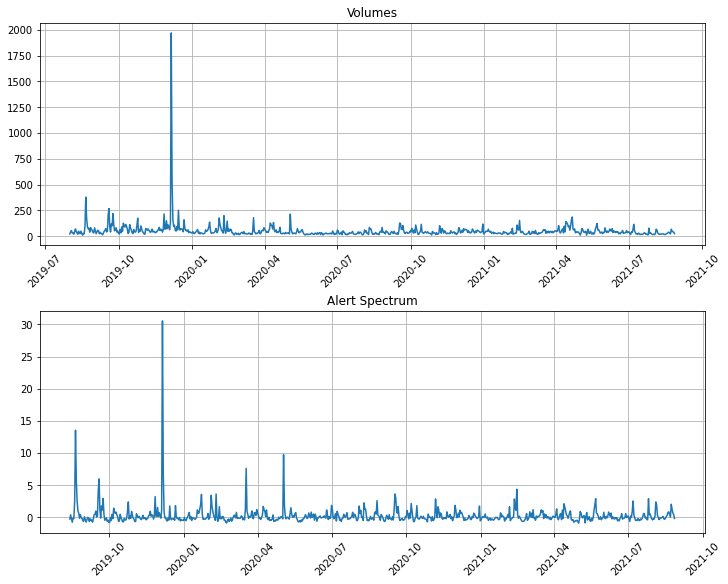

In [6]:
irisres = iris(ferrero_corp)
plot_iris(irisres, 0.5)

In [7]:
iris_spikes = irisres.loc[irisres['mIndex'] >= 0.5]
iris_spikes

,mIndex,volume,sentiment,sign
date_index,,,,
2019-08-20 00:00:00+00:00,2.602240,96,0.373657,False
2019-08-21 00:00:00+00:00,13.554951,378,0.373657,False
2019-08-22 00:00:00+00:00,5.825910,179,0.373657,False
2019-08-23 00:00:00+00:00,2.485722,93,0.373657,False
2019-08-24 00:00:00+00:00,1.006199,71,0.373657,False
...,...,...,...,...
2021-08-19 00:00:00+00:00,0.774941,36,0.524922,True
2021-08-20 00:00:00+00:00,0.858849,38,0.493919,False
2021-08-23 00:00:00+00:00,2.040529,67,0.468272,False


####  Peaks found ####
                           mIndex   sign
date_index                              
2019-08-15 00:00:00+00:00     inf  False
2019-08-19 00:00:00+00:00     inf  False
2019-08-21 00:00:00+00:00     inf  False
2019-08-22 00:00:00+00:00     inf  False
2019-08-23 00:00:00+00:00     inf  False
...                           ...    ...
2021-07-24 00:00:00+00:00     inf   True
2021-07-29 00:00:00+00:00     inf  False
2021-07-30 00:00:00+00:00     inf   True
2021-08-13 00:00:00+00:00     inf  False
2021-08-26 00:00:00+00:00     inf  False

[165 rows x 2 columns]

####  Charts ####


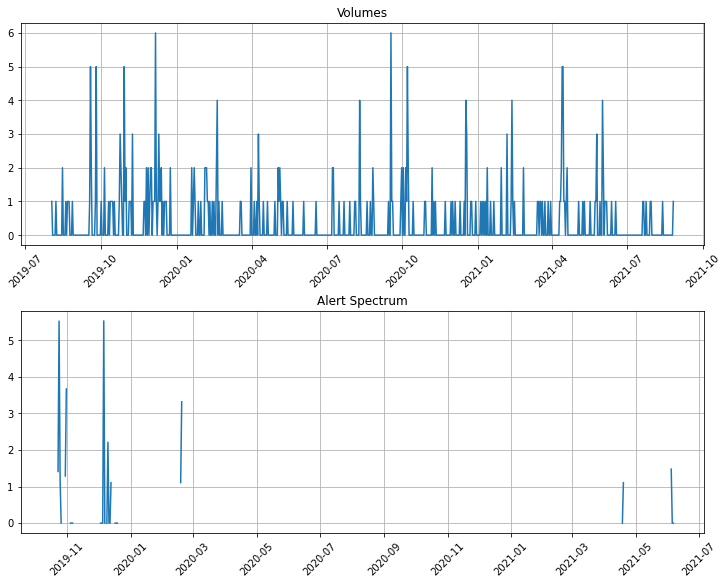

In [8]:
irisres_auth = iris(ferrero_corp_auth)
plot_iris(irisres_auth, 0.5)

In [9]:
iris_auth_spikes = irisres_auth.loc[irisres['mIndex'] >= 0.5]
iris_auth_spikes

,mIndex,volume,sentiment,sign
date_index,,,,
2019-08-20 00:00:00+00:00,NaN,0,NaN,False
2019-08-21 00:00:00+00:00,inf,1,0.39399,False
2019-08-22 00:00:00+00:00,inf,1,0.39399,False
2019-08-23 00:00:00+00:00,inf,1,0.39399,False
2019-08-24 00:00:00+00:00,NaN,0,NaN,False
...,...,...,...,...
2021-08-19 00:00:00+00:00,NaN,0,NaN,False
2021-08-20 00:00:00+00:00,NaN,0,NaN,False
2021-08-23 00:00:00+00:00,NaN,0,NaN,False


In [10]:
iris_join = irisres.merge(irisres_auth, how='outer', left_on='date_index', right_on='date_index')

In [11]:
iris_join

,mIndex_x,volume_x,sentiment_x,sign_x,mIndex_y,volume_y,sentiment_y,sign_y
date_index,,,,,,,,
2019-08-01 00:00:00+00:00,NaN,21,0.373657,False,NaN,NaN,NaN,NaN
2019-08-02 00:00:00+00:00,NaN,40,0.373657,False,NaN,1.0,0.39399,False
2019-08-03 00:00:00+00:00,NaN,53,0.373657,False,NaN,0.0,NaN,False
2019-08-04 00:00:00+00:00,NaN,31,0.373657,False,NaN,0.0,NaN,False
2019-08-05 00:00:00+00:00,NaN,31,0.373657,False,NaN,0.0,NaN,False
...,...,...,...,...,...,...,...,...
2021-08-23 00:00:00+00:00,2.040529,67,0.468272,False,NaN,0.0,NaN,False
2021-08-24 00:00:00+00:00,1.287879,49,0.360722,False,NaN,0.0,NaN,False
2021-08-25 00:00:00+00:00,0.679956,41,0.437569,False,NaN,0.0,NaN,False


In [12]:
%matplotlib qt 

In [13]:
plot_auth_spikes(iris_join, 0.5)

In [14]:
iris_spikes.to_csv('data/spikes/ferrero_corp_spikes.csv')
iris_auth_spikes.to_csv('data/spikes/ferrero_corp_auth_spikes.csv')
iris_join.to_csv('data/spikes/ferrero_corp_merged.csv')